In [1]:
import pandas as pd
import numpy as np
import os
import time
import cv2
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm

import random
from sklearn.preprocessing import  OneHotEncoder

In [2]:
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Dense
from keras.layers import Flatten, Activation, Concatenate
from keras.losses import categorical_crossentropy
from keras.optimizers import adam
import keras.backend as K

Using TensorFlow backend.


In [3]:
FOLDER = '../../data_kaggle/kuzushiji/'
IMAGES = FOLDER + 'train_images/'
CHARS = FOLDER + 'chars/'
MODELS = FOLDER + 'models/'
print(os.listdir(FOLDER))

['unicode_translation.csv', 'train_images', 'sample_submission.csv', 'train.csv', 'kuzushiji-recognition.zip', 'output', 'test_images', 'chars', 'models']


In [4]:
from ssd_utils.ssd_cnn import SSD_CNN
from ssd_utils.ssd_box import DefaultBox, BBoxUtility
from ssd_utils.ssd_gen import Generator
from ssd_utils.ssd_training import MultiboxLoss

In [5]:
df_train = pd.read_csv(FOLDER + 'train.csv')
df_sub = pd.read_csv(FOLDER + 'sample_submission.csv')
unicode_map = {codepoint: char for codepoint, char in pd.read_csv(FOLDER + 'unicode_translation.csv').values}

with open(MODELS + 'ohe.pickle', 'rb') as f:
    ohe = pickle.load(f)

In [6]:
df_sub_idx = df_sub.set_index("image_id")
df_train_idx = df_train.set_index("image_id")
idx_train = df_train['image_id']

In [7]:
num_classes = len(unicode_map)

In [8]:
DB = DefaultBox((1000,1000,1), 10, 100, [2,3], [0.1, 0.1, 0.2, 0.2]) 
DB.compute_output_shape(np.array([1,10,20]))
# var = K.ones(shape=( 100, 100))
# priors = K.eval(DB(var))

(1, 1200, 8)

In [9]:
var1 = K.ones(shape=(1, 14, 14))
priors1 = K.eval(DB(var1)).reshape(-1,8)

var2 = K.ones(shape=(1, 28, 28))
priors2 = K.eval(DB(var2)).reshape(-1,8)

var3 = K.ones(shape=(1, 10, 10))
priors3 = K.eval(DB(var3)).reshape(-1,8)

priors = np.vstack([priors2,  priors1])

In [10]:
BBU = BBoxUtility(num_classes, priors)

In [11]:
len_idx = len(idx_train)
rand_idx = random.sample(list(idx_train), len_idx)
train_keys = rand_idx[:int(len_idx*0.8)]
val_keys = rand_idx[int(len_idx*0.8):]

In [12]:
BBU = BBoxUtility(num_classes, priors, nms_thresh=0.1)

df_idx = df_train_idx 
bbox_util = BBU
batch_size = 2
path_prefix = IMAGES
image_size = (1000, 1000, 1)

gen =  Generator(df_idx = df_train_idx, 
                 bbox_util = BBU,
                 batch_size = batch_size,
                 path_prefix = IMAGES,
                 ohe = ohe,
                 train_keys = train_keys,
                 val_keys = val_keys,
                 image_size=image_size)

In [13]:
ssd_obj = SSD_CNN(num_classes, cnn_size=(100, 100, 1), ssd_size=image_size)
cnn_model = ssd_obj.load(MODELS + 'model.hdf5')
ssd_model = ssd_obj.build_ssd()

In [14]:
lr = 3e-4
ssd_model.compile(optimizer=adam(lr), 
                  loss=MultiboxLoss(num_classes, neg_pos_ratio=1.0).compute_loss)

In [15]:
ssd_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ssd_input (InputLayer)          (None, 1000, 1000, 1 0                                            
__________________________________________________________________________________________________
conv1_1 (Conv2D)                (None, 1000, 1000, 3 320         ssd_input[0][0]                  
__________________________________________________________________________________________________
conv1_2 (Conv2D)                (None, 1000, 1000, 3 9248        conv1_1[0][0]                    
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 500, 500, 32) 0           conv1_2[0][0]                    
__________________________________________________________________________________________________
conv2_1 (C

In [51]:
history = ssd_model.fit_generator(gen.generate(True),
                                  steps_per_epoch=gen.train_batches,
                                  epochs=10,
                                  verbose=1,
                                  validation_data=gen.generate(False),
                                  validation_steps=gen.val_batches)

Epoch 1/10
3104/3104 [==============================] - 4036s 1s/step - loss: 6.0635 - val_loss: 6.6563
Epoch 2/10
3104/3104 [==============================] - 4011s 1s/step - loss: 5.9628 - val_loss: 6.5840
Epoch 3/10
3104/3104 [==============================] - 4026s 1s/step - loss: 5.8681 - val_loss: 6.5976
Epoch 4/10
3104/3104 [==============================] - 4005s 1s/step - loss: 5.8085 - val_loss: 6.7091
Epoch 5/10
3104/3104 [==============================] - 3991s 1s/step - loss: 5.7398 - val_loss: 6.5103
Epoch 6/10
3104/3104 [==============================] - 4016s 1s/step - loss: 5.6798 - val_loss: 6.4177
Epoch 7/10
3104/3104 [==============================] - 4000s 1s/step - loss: 5.6210 - val_loss: 6.3848
Epoch 8/10
3104/3104 [==============================] - 4004s 1s/step - loss: 5.5623 - val_loss: 6.3781
Epoch 9/10
3104/3104 [==============================] - 4010s 1s/step - loss: 5.5342 - val_loss: 6.3564
Epoch 10/10
3104/3104 [==============================] - 3984s 1

In [52]:
key = idx_train[0]
img_path = path_prefix + key + '.jpg'
img_path

'../../data_kaggle/kuzushiji/train_images/100241706_00004_2.jpg'

In [53]:
from keras.preprocessing import image

In [54]:
img = image.load_img(img_path)
img = image.img_to_array(img)/255


In [55]:
img = image.load_img(img_path,target_size=(image_size[1],image_size[0]))
img = image.img_to_array(img)/255

# original_x = img.shape[1]
# original_y = img.shape[0]
# cut_x = original_x // 2
# cut_y = original_y // 3

# img = img[cut_y:cut_y*2, :cut_x, :]
img.shape

(1000, 1000, 3)

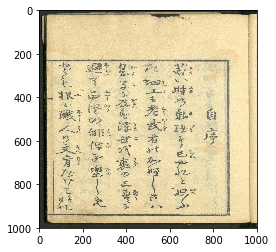

In [56]:
plt.imshow(img)
plt.show()

In [57]:
# img = image.img_to_array((image.array_to_img(img).resize((image_size[1],image_size[0]))))

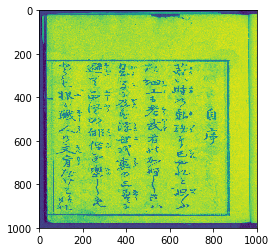

In [58]:
img_gray = img.dot([0.299, 0.587, 0.114])
plt.imshow(img_gray)
plt.show()

In [59]:
pred = ssd_model.predict(img_gray[np.newaxis, :, :, np.newaxis])

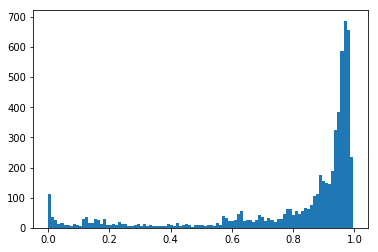

In [60]:
plt.hist(pred[0,:, 4:-8][:,0], bins=100)
plt.show()

In [61]:
pd.Series(ohe.inverse_transform(pred[0,:, 4:-8]).reshape(-1)).value_counts()

U+0031    5846
U+3057       3
U+7D30       2
U+306B       2
U+309D       2
U+3068       1
U+4FF3       1
U+5DF1       1
U+8001       1
U+3089       1
U+8AE7       1
U+5DE5       1
U+4E8C       1
U+4EBA       1
U+8005       1
U+306E       1
U+3092       1
U+6D6E       1
U+7573       1
U+4F55       1
U+76F2       1
U+6B63       1
U+6C17       1
U+8077       1
U+907F       1
U+6587       1
U+4E09       1
U+308B       1
U+3069       1
U+3082       1
dtype: int64

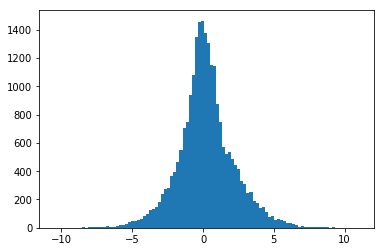

In [62]:
plt.hist(pred[0,:, :4].reshape(-1), bins=100)
plt.show()

In [69]:
pred.shape

(1, 5880, 4799)

In [70]:
result = bbox_util.detection_out(pred, keep_top_k=200)

In [71]:
result[0].shape

(200, 6)

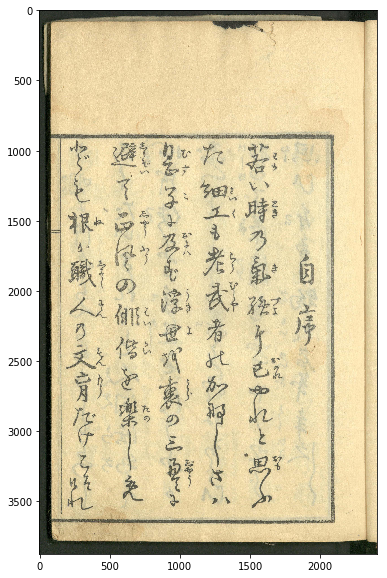

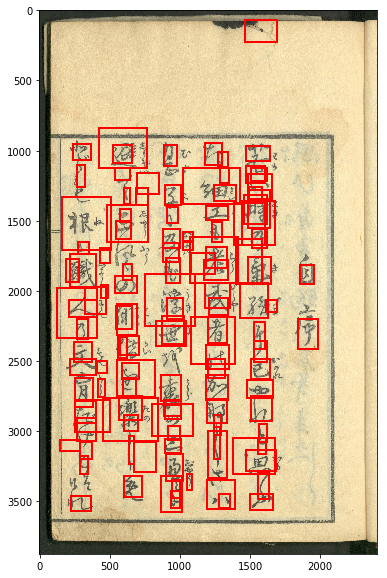

In [84]:
# Parse the outputs.`
num_label = len(unicode_map)

det_label = result[0][:, 0]
det_conf = result[0][:, 1]
det_xmin = result[0][:, 2]
det_ymin = result[0][:, 3]
det_xmax = result[0][:, 4]
det_ymax = result[0][:, 5]

# Get detections with confidence higher than 0.6.
top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.01]

top_conf = det_conf[top_indices]
top_label_indices = det_label[top_indices].tolist()
top_xmin = det_xmin[top_indices]
top_ymin = det_ymin[top_indices]
top_xmax = det_xmax[top_indices]
top_ymax = det_ymax[top_indices]

# plt.figure(figsize=(10,10))
img = image.load_img(img_path)
img = image.img_to_array(img)/255
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()

colors = plt.cm.hsv(np.linspace(0, 1, 4)).tolist()
plt.figure(figsize=(10,10))


plt.imshow(img)
currentAxis = plt.gca()

for i in range(top_conf.shape[0]):
    xmin = int(round(top_xmin[i] * img.shape[1]))
    ymin = int(round(top_ymin[i] * img.shape[0]))
    xmax = int(round(top_xmax[i] * img.shape[1]))
    ymax = int(round(top_ymax[i] * img.shape[0]))
    score = top_conf[i]
    label = int(top_label_indices[i])
#         label_name = voc_classes[label - 1]
#     label_code = np.zeros((1, num_label))
#     label_code[0,label] = 1
#     label_unicode = ohe.inverse_transform(label_code)
#     label_char = unicode_map[label_unicode[0][0]]
    display_txt = '{:0.2f}, {}'.format(score, label)
    coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
#     color = colors[label]
    currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor='red', linewidth=2))
#     currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':'red', 'alpha':0.5})

plt.show()

In [76]:
label = 4138
label_code = np.zeros((1, num_label))
label_code[0,label] = 1
label_unicode = ohe.inverse_transform(label_code)
label_char = unicode_map[label_unicode[0][0]]
label_char

'酒'

In [78]:
ssd_model.save(MODELS + '20190918_ssd_model_f.hdf5', include_optimizer=False)
ssd_model.save(MODELS + '20190918_ssd_model_t.hdf5', include_optimizer=True)